In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import codecs
from io import open
import itertools
import math

import numpy as np  
import pandas as pd 
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import warnings
pd.set_option("display.max_colwidth", 5000)
warnings.filterwarnings("ignore")

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
device

device(type='cuda')

In [0]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Text_Summerization/Reviews.csv")
data.shape

(568454, 10)

In [0]:
data.sort_values(['Time'], ascending=True,inplace=True) # sorting by time

In [0]:
data[['Text','Summary']].tail()

,Text,Summary
477559,"The only reason I am giving it 4 stars instead of 5 stars is for the strange can design -- a substantial amount of food sticks to the inside of the can and in the crevice under the top lip, long before the can is empty, and I have to use a baby food spatula to scrape this off.<br /><br />That being said, Cee Cee kitty devours this. It is not grain free -- as it does have Brown Rice in it (listed as the 8th ingredient, so it DOES have plenty of meat and fish protein), but the meat as well as the other ingredients more than make up for this. Felidae Canned Cat Food for Adult Cats and Kittens, Formula with Chicken, Turkey, Lamb and Ocean Fish also smells very fresh and not garbagey like some of the supermarket cat foods. And since Cee Cee is battling hyperthryoidism as well as a heart murmur, I want to buy her the best food I can afford. This may be a bit pricey but it is VERY dense, so it goes a long way.","Cee Cee LOOOVES it, This I Know"
143110,"Very pleased with the quality of the espresso. The pods are sturdy enough to withstand the pressure of the water in brewing - no messy grounds from broken pods to threaten the functioning of the machine. The crema is awesome, taste is smooth.",Wonderful taste!
110116,"I just love it, and I am Not a major Indian cooking fan--just enough. Really, it mixes with anything you are doing like <a href=""http://www.amazon.com/gp/product/B000FIXT2I"">Steamed Brown Rice Bowl, Organic, Microwaveable, 7.4-Ounce Bowls (Pack of 12)</a> (I use these for convenience, and then I don't eat the whole pot of rice). In many kinds of soups, etc. Beef it up with some <a href=""http://www.amazon.com/gp/product/B001FA1KLW"">Amore Tomato Paste, 4.5-Ounce Tubes (Pack of 12)</a>, which is so, so convenient. Sweeten to taste if you prefer. Here's the best artificial sweetener on Amazon <a href=""http://www.amazon.com/gp/product/B0019LTH3U"">NuNaturals Nustevia Alcohol Free Stevia Glass Bottle Liquid, 2-Ounce</a>. (Stop using Splenda which contains three Chlorine moities. It's essentially bleach, folks.) Enjoy, lentils are so healthy, and this way they really have flavor!<br />FYI: This costs $3-5/PER PACK at our local stores when you can find it. It is Not overpriced, as someone here said.","It's FANTASTIC! Mixes with Many kinds of Soups, etc. Yes."
468445,"I enjoy drinking this in a greek yogurt smoothie in the morning. I use greek yogurt, pineapple, banana, and green superfood chocolate powder! Delicious!",Great Product
440835,"Aside from a non-flashy name, this is a great coffee. Very smooth, perfect! If is my favorite at this point, even over other flavored coffee.",Boring name but great coffee


In [0]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na
data.shape

(393565, 10)

# Preprocessing 

1. Convert everything to lowercase
2. Remove HTML tags
3. Contraction mapping
4. Remove (‘s)
5. Remove any text inside the parenthesis ( )
6. Eliminate punctuations and special characters
7. Remove stopwords
8. Remove short words

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [3]:
'''import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - set(['not'])
stop_words
stop_words = set(stopwords.words('english')) - set(['not','no'])'''
def clean(text, summary = True):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    if summary:
      tokens = [w for w in newString.split()]
      long_words=[]
      for i in tokens:
          if len(i)>1:                  #removing short word < 2
              long_words.append(i)  
      print(len(long_words))
      if len(long_words)==0:
          return "empty_summary_field"
      else:
          return (" ".join(long_words)).strip()
    else:
      tokens = [w for w in newString.split() if not w in stop_words]
      long_words=[]
      for i in tokens:
          #print(len(i))
          if len(i)>=3:                  #removing short word length < 3 
              long_words.append(i)  
      return (" ".join(long_words)).strip()

text = "It is not that great product to have as me"
#text = "I L Y"
print((clean(text,summary=True)))

10
it is not that great product to have as me


In [0]:
%%time

# There are few sentences with summary as "no"

# If you working with LSTM’s or other models which capture the semantic meaning and the
# meaning of a word depends on the context of the previous text, then it becomes important not to remove stopwords.

stop_words = set(stopwords.words('english')) - set(['not'])
def clean(text, summary = True):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    if summary:
      tokens = [w for w in newString.split()]
      long_words=[]
      for i in tokens:
          if len(i)>1:                  #removing short word < 2
              long_words.append(i)  
      #print(len(long_words))
      if len(long_words)==0:
          return "empty_summary_field"
      else:
          return (" ".join(long_words)).strip()
    else:
      tokens = [w for w in newString.split() if not w in stop_words]
      long_words=[]
      for i in tokens:
          #print(len(i))
          if len(i)>=3:                  #removing short word length < 3 
              long_words.append(i)  
      return (" ".join(long_words)).strip()


cleaned_text = []
cleaned_summ = []
cleaned_text.append([clean(t,summary=False) for t in data['Text']])
cleaned_summ.append([clean(t,summary=True) for t in data['Summary']])

data['cleaned_text']=cleaned_text[0]
data['cleaned_summary']=cleaned_summ[0]

#Ex: There are few sentences with summary as "no". After clean() this would be an empty string in cleaned_summary. so deleting the entire row.

data['cleaned_summary'].replace("empty_summary_field", np.nan, inplace=True)
data.dropna(axis=0,inplace=True)


CPU times: user 3min 46s, sys: 2.12 s, total: 3min 48s
Wall time: 3min 48s


In [0]:
data.shape

(393215, 12)

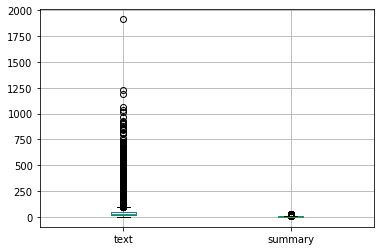

In [0]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(str(i).split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(str(i).split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
#length_df.hist(bins = 30)
length_df.boxplot()
plt.show()

1. maximum length of a sentence is 1892

In [0]:
len(data)

393215

In [0]:
# Here we are only taking data with text length <= 100 and summary length <= 10
data = data[[len(str(txt).split(" ")) <= 100 and len(str(summ).split(" ")) <= 10 for txt,summ in zip(data['cleaned_text'],data['cleaned_summary'])]]
print(len(data))

# saving cleaned_text, cleaned_summary to csv
data[['cleaned_text','cleaned_summary']].to_csv("/content/drive/My Drive/Colab Notebooks/Text_Summerization/Reviews_cleaned.csv",index=False)

365941


# Loading Cleaned Data

In [4]:
data_cleaned = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Text_Summerization/Reviews_cleaned.csv")
data_cleaned.shape

(365941, 2)

In [5]:
data_cleaned.tail(2)

,cleaned_text,cleaned_summary
365939,enjoy drinking greek yogurt smoothie morning use greek yogurt pineapple banana green superfood chocolate powder delicious,great product
365940,aside non flashy name great coffee smooth perfect favorite point even flavored coffee,boring name but great coffee


In [0]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(data_cleaned['cleaned_text'],data_cleaned['cleaned_summary'],test_size=0.05,random_state=0) 

In [7]:
print(len(x_train))
print(len(x_val))

347643
18298


In [0]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
RARE_WORD = 3  # word not present in train data replace with this word

class Voc:
    def __init__(self):
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", RARE_WORD:"UNKNOWN"}
        self.num_words = 4  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [9]:
def toPairs(x_train,y_train,x_val,y_val):
  pairs_train = []
  pairs_val = []
  for x,y in zip(x_train,y_train):
    pairs_train.append([str(x), str(y)])

  for x,y in zip(x_val,y_val):
    pairs_val.append([str(x), str(y)])

  return pairs_train,pairs_val

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(pairs_train,voc):
    print("Counting words...")
    for pair in pairs_train:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc

# Load/Assemble voc and pairs
voc = Voc()
save_dir = os.path.join("/content/drive/My Drive/Colab Notebooks/Text_Summerization/", "save")
pairs_train,pairs_val = toPairs(x_train,y_train,x_val,y_val)
voc = loadPrepareData(pairs_train,voc)
# Print some pairs to validate
print("\npairs:")
for pair in pairs_train[:5]:
    print(pair)
print(len(pairs_train))
print(len(pairs_val))

Counting words...
Counted words: 105623

pairs:
['gluten free years first cookies tasted actually taste like cookie cardboard taste mentioned hard crunchy cookie especially love using similar biscotti dunking coffee', 'yum']
['used product years put handful dried apples bottom bowl put oatmealon top zap add walnuts dried cranberries yummy', 'great product']
['received satsuki azalea gift person gave excited box opened wat found box small bush not cut not trained nothing even close picture not mean flowers well thought job train means however intent gift giver', 'just small bush']
['love small bags perfect take lunch adds nice crunch sandwich bold flavor little bit spicier original', 'delicious and crunchy']
['tried different sugar substitutes one terrible anyone given clue bad would not purchased use xylitol stevia sweetner tried say not buy product want sweeten anything not work cannot give away one wants sorry review honest', 'not worth it']
347643
18298


In [10]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs_train = trimRareWords(voc, pairs_train, MIN_COUNT)

keep_words 39230 / 105619 = 0.3714
Trimmed from 347643 pairs to 292057, 0.8401 of total


In [11]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] if word in voc.word2index.keys() else RARE_WORD for word in sentence.split(' ')] + [EOS_token]

def max_tar_len(indexes_batch):
  max_val = 0
  # print("indexes_batch",indexes_batch)
  for i in indexes_batch:
    if max_val < len(i):
      max_val = len(i)
  return max_val

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    #print(max(len(indexes_batch[0]),len(indexes_batch[1]),len(indexes_batch[3]),len(indexes_batch[2]),len(indexes_batch[4])))
    #max_target_len = max([max_tar_len(indexes,indexes_batch) for indexes in indexes_batch])
    max_target_len = max_tar_len(indexes_batch)
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs_train) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)



input_variable: tensor([[ 2495,   337,   250,  4984,     5],
        [   18,   120,    26,    63,   848],
        [ 6677,  1057,  8255,   579,  2623],
        [   99,  4087,  3057,   458,  3002],
        [ 1301,   229,  1165, 11211,  2623],
        [  487,    99,   464,    53,   366],
        [ 2534, 12787,   551,   297,  2623],
        [ 1248,  1057,   551,    72,  1415],
        [ 6099, 12788,  1126,    72,    57],
        [ 2386,   488,  4820,    81,   954],
        [  287,    39, 11196,   501,   796],
        [ 8101,  6652,   143,  1797,   708],
        [ 1221,   163,   733,  1026,  3500],
        [ 1633,  1057,   250,    23,  1237],
        [  290,   754,  3551,   278,   535],
        [ 4252,   365,  5673,   942,   366],
        [ 1008,  2387,   213,  1371,  1104],
        [   72,  7973,  1388,  8382,  2623],
        [  323,  3006,   551,   344,    84],
        [ 2921,   226,    40,   297,    80],
        [ 7085,    87,    72,   310,   504],
        [ 4252, 12177,  1514,    18,   

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [0]:
# Attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [0]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [0]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [0]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


'''def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)'''


def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, loadFilename,plot_every):

    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        if iteration % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                #'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                #'en_opt': encoder_optimizer.state_dict(),
                #'de_opt': decoder_optimizer.state_dict(),
                #'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

    #showPlot(plot_losses)

In [18]:
# Configure models
model_name = 'cb_model'
#attn_model = 'dot'
attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.2
batch_size = 128
save_dir = os.path.join("/content/drive/My Drive/Colab Notebooks/Text_Summerization/", "save")

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 20000
#loadFilename = os.path.join(save_dir, model_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [19]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 20000
print_every = 1000
save_every = 10000
plot_every = 100

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs_train, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, loadFilename,plot_every)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1000; Percent complete: 5.0%; Average loss: 4.0339
Iteration: 2000; Percent complete: 10.0%; Average loss: 3.3546
Iteration: 3000; Percent complete: 15.0%; Average loss: 3.1093
Iteration: 4000; Percent complete: 20.0%; Average loss: 2.9494
Iteration: 5000; Percent complete: 25.0%; Average loss: 2.8231
Iteration: 6000; Percent complete: 30.0%; Average loss: 2.7200
Iteration: 7000; Percent complete: 35.0%; Average loss: 2.6368
Iteration: 8000; Percent complete: 40.0%; Average loss: 2.5495
Iteration: 9000; Percent complete: 45.0%; Average loss: 2.4823
Iteration: 10000; Percent complete: 50.0%; Average loss: 2.4042
Iteration: 11000; Percent complete: 55.0%; Average loss: 2.3478
Iteration: 12000; Percent complete: 60.0%; Average loss: 2.2902
Iteration: 13000; Percent complete: 65.0%; Average loss: 2.2307
Iteration: 14000; Percent complete: 70.0%; Average loss: 2.1690
Iteration: 15000; Percent complete: 75.0%;

In [0]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length=10):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [0]:
MAX_LENGTH=100
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = clean(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Summary:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [0]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

In [0]:
pairs_val[10:50]